# Formula1 Qualifying Prediction Which Telemetry Features are Important?

Author : Ben Palmer\
Date : 02/11/2022

# Summary:

In summary we have shown that the features we created by aggregating the telemetry data from the individual laps has predictive power in Qualifying Position and Lap Time delta.

- Some of the variables have some linearity with the target variable
- 3 Different feature importance techniques picked out different variables of interest. However they all agreed that some of the features generated from the telemetry data were useful in predicting the Target Variable

The result of this investigation is we can confirm that the features generated are useful and that we can proceed to download the data for the rest of the GrandPrix's between 2018 to 2022 and generate the same features that were generated on the sample dataset.


# Introduction:

The aim of this notebook is to test the features that were generated on the sample telemetry data in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb). Are they useful in the prediction of the Target Variables:
- Qualifying Position
- Lap Time Delta

In the previous notebook the telemetry for 10 GrandPrix's for every driver was downloaded. Every possible feature related to the Circuit characteristics, Driver Characteristics & Car Characteristics that could be thought off was generated to aggregate the data to a record per driver per Grand Prix. This created far too many features which would cause dimensionality issues. The aim of this notebook is to find out which features are good predictors of the Target Variables and whether we could reduce dimensionality enough to be able to generate resonable models to predict the targets. If so we can then proceed to download all the data from 2018 to 2022 and run the feature aggregation pipeline for all the laps in all the Qualifying sessions.



# Table of Contents:

1. [Explortory Analysis on new features](#eda)\
    1.1 [Load the Data](#load)\
    1.2 [Evaluate & Bin the Target Variables](#bin)\
    1.3 [Evaluate Numerical Variables](#num)\
    1.4 [Evaluate Categorical Variables](#cat)

2. [Prepare Data for modelling](#prep)\
    2.1 [Feature Engineer Country](#country)\
    2.2 [Test Train Split](#testrain)\
    2.3 [Feature Engineer Categorical Variables](#onehot)\
    2.4 [Label Target Variables](#label)

3. [Feature Importance](#feature)\
    3.1 [Random Forest Feature Importance](#rf)\
    3.2 [Select K Best](#kbest)\
    3.3 [Principal Component Analysis](#pca)\
    3.4 [Summary of Feature Importance](#sumfeature)

4. [Summary](#sum)

5. [Next Steps](#steps)

6. [Appendix](#appendix)





### Imports

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scripts import ds_ultils
import plotly.express as px
from scripts.f1_ultils import *
from scripts.ds_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

# Exploratory Analysis on the new features 
<a id="eda"></a>

This section we will load the newly created data, and explore the features created.

## Load data
<a id="load"></a>

In [79]:
qualifying_data=pd.read_csv('./data/model_data/formula1_2018_2019_5GP_aggregated.csv')

In [80]:
qualifying_df= qualifying_data.copy()

In [81]:
qualifying_df.head(5)

raceId driverRef circuitRef country nationality_drivers constructorRef  \
0     993    alonso  catalunya   Spain               Spain        mclaren   
1     993    bottas  catalunya   Spain             Finland       mercedes   
2     993  ericsson  catalunya   Spain              Sweden         sauber   
3     993     gasly  catalunya   Spain              France     toro_rosso   
4     993  grosjean  catalunya   Spain              France           haas   

  nationality_constructors    year  lat_x    lng_x  ...  avglap_Sector1  \
0                       UK  2018.0  41.57  2.26111  ...       22.835222   
1                  Germany  2018.0  41.57  2.26111  ...       23.765333   
2              Switzerland  2018.0  41.57  2.26111  ...       24.981800   
3                    Italy  2018.0  41.57  2.26111  ...       23.887500   
4                      USA  2018.0  41.57  2.26111  ...       23.728071   

   avglap_Sector2  avglap_Sector3  fastestlap_percentagerainfall  \
0       30.568444       28.153444                          100.0   
1       31.612500       30.362000                          100.0   
2       36.156200       30.434600                            0.0   
3       32.403125       29.813000                          100.0   
4       32.493429       29.558929                          100.0   

   fastestlap_track_temperature  fastestlap_humidity  \
0                          26.4                 79.2   
1                          26.4                 79.2   
2                          27.6                 76.1   
3                          26.8                 77.8   
4                          27.1                 77.1   

   avg_lap_percentagerainfall  avg_lap_track_temperature  avg_lap_humidty  \
0                       100.0                  27.255556        77.311111   
1                       100.0                  26.950000        77.883333   
2                         0.0                  27.620000        76.440000   
3                       100.0                  27.462500        76.587500   
4                       100.0                  27.135714        77.350000   

   fastest_lap_milliseconds_clean  
0                         77721.0  
1                         76213.0  
2                         79493.0  
3                         78463.0  
4                         77699.0  

[5 rows x 102 columns]

In [82]:
print(f' This data has {qualifying_df.shape[0]} rows and {qualifying_df.shape[1]} columns')

 This data has 197 rows and 102 columns


Since we have only taken a sample of 10 grandprix's with 20 drivers we have just under 20 rows, as some races not all 20 drivers competed. In our feature aggregation we created 94 columns. This is only a sample of the complete F1live api dataset which spans 2018 to 2022, with ~ 20 GrandPrix's a season. Therefore the estimated complete dataset would be 20 drivers * 20 GrandPrix's * 5 years ~ 2000 rows. This will still be a very small dataset, therefore 94 features is far too much and will cause dimensionality issues as the models over fit the data. 

Therefore we need to reduce the dimensionality to just the features that matter. That is the aim of the this notebook to find out those features:

## Data Dictionary:
<a id="datadict"></a>
As described in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb), the data from all the laps and telemetry per lap is aggregated by engineering a series of features to capture all the data. These features try to capture the characteristics of the **circuit**,**car** and **driver**. The data dictionary of all the features generated is as follows:

- `raceId`: unique id number for each GrandPrix
- `driverRef`: Driver Name 
- `number`: Unique number chosen by the drivers for numbering the car they drive in
- `name`: GrandPrix name
- `circuitRef` : Circuit reference 
- `country` : Country of circuit
- `nationality_drivers`: Nationality of Drivers- assigned as a country same format as circuit 
- `constructorRef`: Team name reference 
- `nationality_constructors`: Nationality of the Team
- `year`: Year of the Grand Prix 
- `lat_x`: Laitude of the Grand Prix
- `lng_x` : Longitude of the Grand Prix 
- `alt`: Alitude of the circuit 
- `quali_position` : Qualifying Position **Target Variable** 
- `dob` driver date of birth
- `positionOrder` : Position order is the results of the Sunday Race
- `points` : Points are the points gained by the driver in that race
- `points_drivers` : This is the season aggreagtion of points - how the driver is doing up until that race
- `position_drivers` : This is the Position in the Standings for the driver after that race
- `wins_drivers` : Number of wins the driver had
- `points_constructors` : Number of points the team have aggregated in the season
- `position_constructors` : Position in the teams standing for that team
- `wins_constructors` : Number of wins for the team
- `points_constructor_ind_races` : Amount of points the team got in that race
- `fastest_lap_milliseconds` :**Target Variable** Fastest Lap time in milliseconds - this is calculated by moving the Q1 (qualifying1) times of the last 5 drivers to Q3 (qualifying 3 session), and the Q2 (qualifying 2) times of the drivers 10-15 to Q3. In formula 1 the qualifying session is broken down into 3 sessions. In each session the drivers set out to do there fastest times. In Qualifying 1 the bottom 5 are knocked out, in Qualifying 2 the next bottom 5. Leaving the top ten to fight it out for the order of the top ten races for the race. However it was found that some drivers who make it in to the top ten shoot out perform worse than they did in qualifying2, this can impact the prediction

- `circuit_length` - length of circuit in (m)
- `circuit_total_straight` -total length of straights in the lap (m)
- `circuit_mean_straight` - mean length of straights in the lap (m)
- `circuit_max_straight` - max length of straight in the lap (m)
- `circuit_total_corner_length` - total length of all the corners in the lap (m)
- `circuit_mean_corner_length` - mean corner length (m)
- `circuit_max_corner_length` - max corner length (m)
- `circuit_total_corner_curvature` - sum of corners curvature found as average of second derivative for that corner
- `circuit_mean_corner_curvature` - mean corner curvature as average of second derivative for each corner
- `circuit_max_corner_curvature` - max corner curvature 
- `circuit_std_corner_curvature` - variance of corner curvature
- `circuit_number_of_corners` - number of corners in the circuit
- `max_max_speed` - top speed of all the laps by the driver (km/h)
- `max_fastest_lap_speed` - top speed on the fastest lap by the driver (km/h)
- `var_fastest_lap_speed` - variance in fastest lap speed 
- `min_fastest_lap_speed` - minimum of fastest lap speed (km/h)
- `max_lap_speed` -average max lap speed over all the laps in qualifying (km/h)
- `var_lap_speed` - variance in lap speed over all the laps in qualifying
- `bottom_lap_speed` - average bottom speed in the lap over all the laps in qualifying(km/h)
- `mean_straight_speed`- average straight speed over all the laps (km/h)
- `var_straight_speed` - variance in straight speed over all the laps 
- `max_fastest_accleration`- m/s2 maximum accleration on the fastest lap
- `var_fastest_accleration` - variance in accleration on the fastest lap
- `min_fastest_accleration`- minimum accleration on the fastest lap
- `mean_max_lap_accleration`- mean fastest lap accleration
- `mean_var_lap_accleration` - average variance in lap accleration over all the laps
- `mean_min_lap_accleration` - average minimum lapp accleration over all the laps
- `max_fastest_lap_rpm` - maximum rpm on the fastest lap
- `var_fastest_lap_straight_rpm`- variance in the fastest lap rpm on the straight
- `mean_fastest_lap_straight_rpm` - average fastest lap rpm on the straight
- `max_max_rpm` - maximum rpm on the fastest lap
- `mean_var_straight_rpm` - average variance in rpm on the straight over all the laps
- `mean_straight_rpm` - mean engine rpm over all teh alps
- `avg_gear1_time` - avg gear 1 time over all laps
- `avg_gear2_time`- avg gear 2 time over all laps
- `avg_gear3_time` - avg gear 3 time over all laps
- `avg_gear4_time` - avg gear 4 time over all laps
- `avg_gear5_time` - avg gear 5 time over all laps
- `avg_gear6_time` - avg gear 6 time over all laps
- `avg_gear7_time` - avg gear 7 time over all laps
- `avg_gear8_time` - avg gear 8 time over all laps
- `avg_gear1_time_fl`- avg gear 1 time on the fastest lap
- `avg_gear2_time_fl` - avg gear 2 time on the fastest lap
- `avg_gear3_time_fl` - avg gear 3 time on the fastest lap
- `avg_gear4_time_fl`- avg gear 4 time on the fastest lap
- `avg_gear5_time_fl`- avg gear 5 time on the fastest lap
- `avg_gear6_time_fl`- avg gear 6 time on the fastest lap
- `avg_gear7_time_fl`- avg gear 7 time on the fastest lap
- `avg_gear8_time_fl`- avg gear 8 time on the fastest lap
- `avg_lap_time_on_brake`- avg lap time the driver is on the brake over all laps (s)
- `avg_lap_distance_on_brake` - avg lap distance the driver travels on the brake over all laps (m)
- `avg_lap_time_on_DRS` - avg lap time the driver has the rear wing flap (DRS) open (s)
- `avg_lap_distance_on_DRS` - avg lap distane the driver has the rear wing flap (DRS) open (m)
- `avg_lap_bottom_speed_corner` - avg lap bottom speed in the corner over all the laps (km/h)
- `avg_lap_max_speed_corner` - maximum speed in the corners average over all laps (km/h)
- `avg_lap_bottom_speed_tightest_corner` - speed in the tightest corner averaged over all the laps (km/h)
- `fl_lap_time_on_brake` - Fastest lap time the driver is on the brake (s)
- `fl_lap_distance_on_brake` - fastest lap distance the driver is on the brake (m)
- `fl_lap_time_on_DRS` - fastest lap time the driver has the rear wing open (s)
- `fl_lap_distance_on_DRS` - fastest lap distance the driver travels with rear wing open (s)
- `fl_lap_bottom_speed_corner`- average bottom speed in the corners on the fastest lap
- `fl_lap_max_speed_corner` - maximum speed in the corners on the fastest lap (km/h)
- `fl_lap_bottom_speed_tightest_corner` - minimum speed in the tightest corner on the fastest lap
- `fl_tyre` - tyre the driver was on the fastest lap
- `fl_tyre_life` - how many laps have been completed on this tyre prior to this lap on the fastest lap
- `fastestlap_Sector1` - sector 1 time for the fastest lap (s)
- `fastestlap_Sector2` - sector 2 time for the fastest lap (s)
- `fastestlap_Sector3` - sector 3 time for the fastest lap (s)
- `avglap_Sector1` - average lap time in sector 1 (s)
- `avglap_Sector2` - average lap time in sector 2 (s)
- `avglap_Sector3` - average lap time in sector 3 (s)
- `fastestlap_percentagerainfall` - amount of rain fall on the fastest lap 
- `fastestlap_track_temperature` - temperature of the track of the fastest lap (celcius)
- `fastestlap_humidity` - humidity of the fastest lap
- `avg_lap_percentagerainfall` - average of all the laps amount of rainfall
- `avg_lap_track_temperature'` -average track temperature over all the laps
- `avg_lap_humidty` - average humidity over all the laps
- `age` - age of the driver (year - dob)



Position, wins and points are all after the event as happened so they are indirect targets as they explain the result of the driver. Therefore they need to be removed. 

Later we may feature engineer average position that season, and average results leading up to the race but first we need to remove that and define our targets

## Drop addittional prediction features

In [83]:
qualifying_df.drop(columns=['positionOrder',
 'points',
 'points_drivers',
 'position_drivers',
 'wins_drivers',
 'points_constructors',
 'position_constructors',
 'wins_constructors',
 'points_constructor_ind_races'],axis=1,inplace=True)

In [84]:
#drop id column as we have an index variable
qualifying_df.drop(columns=['qualifyId'],axis=1,inplace=True)

## Evaluate & Bin Target variables
<a id="bin"></a>

Next lets look at the distribution of the target variables.

We are aiming to predict qualifying position and time

<AxesSubplot: xlabel='quali_position', ylabel='Count'>

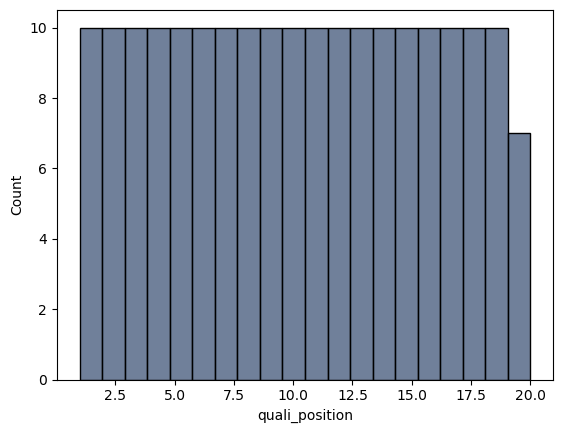

In [85]:
sns.histplot(data = qualifying_df ,x='quali_position',bins=20)

Qualifying Position is the result of the qualifying. This result controls the start order for the multi lap race the following day. The result is calculated in order of the fastest lap time, therefore the result is a integer variable and every race there is a driver in every position, so the distribution is uniform. THe last position of 20th has a slight dip, this is because in a few races not all 20 drivers competed and hence there was not a 20th position assigned for that race.


How about the Fastest Lap Time?

<AxesSubplot: xlabel='fastest_lap_milliseconds', ylabel='Count'>

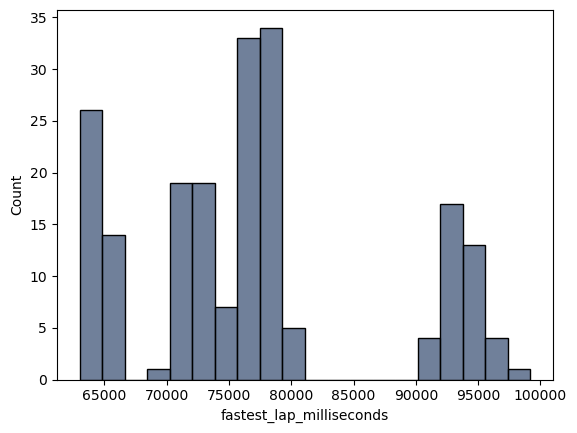

In [86]:
sns.histplot(data = qualifying_df ,x='fastest_lap_milliseconds',bins=20)

For fastest lap times there are multiple normal distributins, this is because the circuit length has the biggest variance on the results. There are clusters of times that occur due to cluster of circuits which take a similar length to complete. 

Therefore the biggest impact on the lap time is the circuit length and not the driver and car abilities. To redice the impact of the circuit we will create a new target feature:
`Lap Time Delta` this will be the time difference between the fastest time for that qualifying session and the drivers time. Hence the time delta to pole position. Tish should remove the variability of the circuit length. 

### Binning Qualifying Position
As seen above qualifying position is a uniform distribution, there is a  1st place, 2nd place etc in every qualifying session. This may impact a models predictability as it may be hard to for a model to predict a ranked result when it is trying to find a numerical relationship. This is a cross between a classification and regression problem. It could be considered a classification with classes 1,2,3 etc or regression with continuous numbers between 1 to 20. To start with we will consider this a classification problem and tohelp the model predict we will bin the result into bins of 5. Therefore instead of having 20 classes to predict we will have 4.

In [87]:
qualifying_df['quali_position_binned'] = pd.cut(qualifying_df['quali_position'],bins=4,labels=['0_to_5','5_to_10','eleven_to_15','fifteen_&_above'])

<AxesSubplot: xlabel='quali_position_binned', ylabel='Count'>

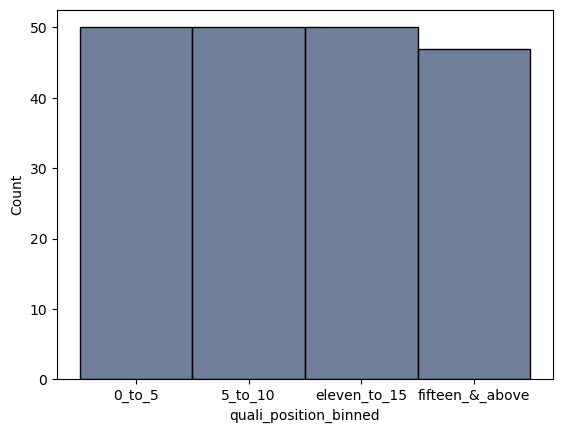

In [88]:
sns.histplot(data = qualifying_df ,x='quali_position_binned',bins=20)

### Lap Time Delta engineering and binning

As discussed above we want to re engineer the fastest lap time into a lap time delta to reduce the variance caused by circuit length. We can do that by finding the times for each race and calculating the difference to fastest time.

In [89]:
races = qualifying_df['raceId'].unique()
for race in races:
    query = (qualifying_df['raceId'] == race)
    fastesttime= qualifying_df.loc[(query) & (qualifying_df['quali_position'] == 1),'fastest_lap_milliseconds'].values
    
    qualifying_df.loc[query,'lap_timedelta_milliseconds']=(np.where(qualifying_df.loc[query,'quali_position']==1,0,(fastesttime-qualifying_df.loc[query,'fastest_lap_milliseconds'])))

In [90]:
qualifying_df['lap_timedelta_milliseconds'].describe()

count     197.000000
mean    -1647.538071
std      1182.851464
min     -7569.000000
25%     -2236.000000
50%     -1558.000000
75%      -850.000000
max       753.000000
Name: lap_timedelta_milliseconds, dtype: float64

We can see we have successful created the lap time delta. Majority of the times are negative since the drivers are slower than the fastest driver. Howeve we have some times which are faster. How can this be?

Lets investigate these times.

We have worked out they come from the Hungarian GrandPrix in 2018

In [91]:
query = (qualifying_df['circuitRef']== 'hungaroring') & (qualifying_df['year'] == 2018)
qualifying_df.loc[query,['quali_position','lap_timedelta_milliseconds','fastest_lap_milliseconds','fastest_lap_milliseconds_clean']]

quali_position  lap_timedelta_milliseconds  fastest_lap_milliseconds  \
58            11.0                      -789.0                   78208.0   
59             2.0                       296.0                   77123.0   
60             8.0                     -1010.0                   78429.0   
61            14.0                     -1222.0                   78641.0   
62             6.0                     -1158.0                   78577.0   
63            10.0                      -482.0                   77901.0   
64             1.0                         0.0                   77419.0   
65            13.0                      -486.0                   77905.0   
66             9.0                      -895.0                   78314.0   
67            17.0                     -1398.0                   78817.0   
68             7.0                       479.0                   76940.0   
69            18.0                     -1723.0                   79142.0   
70            19.0                     -1781.0                   79200.0   
71             3.0                      -107.0                   77526.0   
72            12.0                     -1121.0                   78540.0   
73             5.0                      -410.0                   77829.0   
74            20.0                     -1882.0                   79301.0   
75            15.0                     -1141.0                   78560.0   
76            16.0                     -1363.0                   78782.0   
77             4.0                       753.0                   76666.0   

    fastest_lap_milliseconds_clean  
58                         78208.0  
59                         77123.0  
60                         78429.0  
61                         78641.0  
62                         78577.0  
63                         77901.0  
64                         77419.0  
65                         77905.0  
66                         78314.0  
67                         78817.0  
68                         76940.0  
69                         79142.0  
70                         79200.0  
71                         77526.0  
72                         78540.0  
73                         77829.0  
74                         79301.0  
75                         78560.0  
76                         78782.0  
77                         76666.0

We can see there are two times, position 7 and 4 which have faster times than driver in first. We can look at the original results for this race by going back the original dataframe:

In [92]:
ergast_combined_df=pd.read_csv('./data/clean/combined_ergast_clean.csv')

In [93]:
ergast_combined_df.loc[ergast_combined_df['raceId']==1000,['q2','q3']]

q2        q3
3911  1:32.762  1:36.186
3912  1:28.636  1:36.210
3913  1:30.771  1:36.743
3914  1:31.286  1:37.591
3915  1:31.178  1:38.032
3916  1:32.590  1:38.128
3917  1:32.968  1:39.858
3918  1:33.650  1:40.593
3919  1:35.214       NaN
3920  1:36.442       NaN
3921  1:36.506       NaN
3922  1:37.075       NaN
3923       NaN       NaN
3924       NaN       NaN
3925       NaN       NaN
3926       NaN       NaN
3927       NaN       NaN
3928       NaN       NaN
3929  1:31.242  1:35.658
3930  1:32.081  1:35.918

Here we are showing the the qualifying session fastest's time for Q2 and Q3. As previously discussed qualifying occurs in 3 sessions. In Q1 the slowest 5 drivers do not proceed to Q2. The same happens in Q2, drivers set there best times and the last 5 do not progress to Q3. In Q3 the top ten go out to set there fastest times and decide the order for the top ten drivers. In this race we can see that the fastest times were actually set in Q2 and the drivers perfomed worse in Q3. Most likely due to rain or change in weather between sessions. 

Since we took the Q3 times for the top ten, Q2 times for 10-15 and Q1 times for 15-20, there are drivers who performed better than the first driver.

This can be solved by either searching for the fastest time and then doing the lap time delta, or just taking the fastest time for each driver across the sessions. This will be corrected for the time we download and aggregate the features for the complete dataset.

For this analysis we can just truncate any values greater than 0 as 0.

<AxesSubplot: xlabel='lap_timedelta_milliseconds', ylabel='Count'>

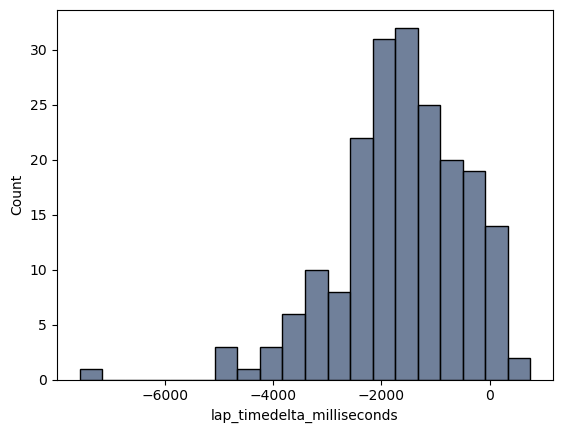

In [94]:
sns.histplot(data = qualifying_df ,x='lap_timedelta_milliseconds',bins=20)


The distribution shows a 16 or so values above 0 which would be truncated:

In [95]:
qualifying_df['lap_timedelta_milliseconds'] = np.where(qualifying_df['lap_timedelta_milliseconds'] >0,0,qualifying_df['lap_timedelta_milliseconds'])

In [96]:
qualifying_df['lap_timedelta_milliseconds'].describe()

count     197.000000
mean    -1655.294416
std      1169.990783
min     -7569.000000
25%     -2236.000000
50%     -1558.000000
75%      -850.000000
max         0.000000
Name: lap_timedelta_milliseconds, dtype: float64

After the truncation we now only have a max at 0.

### Lap Time Delta binning

As we can see from the distribution we have a normal to slightly positive skewed distribution. The mean is around 1600 milliseconds behind pole with the median at 1500. The data is a continuous variable and hence could be considered a regression problem. However it is predicted that this may be a challenge to predict the values and hence converting it to a classification problem may improve the models predictive power.

We can split the bins at the quartiles and hence make sure the classes are balanced.

In [97]:
qualifying_df['lap_timedelta_seconds_binned'] = pd.qcut(qualifying_df['lap_timedelta_milliseconds'],q=4,labels=['>2.2s','2.2-1.5s','1.5-0.8s','0.8-0s'])

<AxesSubplot: xlabel='lap_timedelta_seconds_binned', ylabel='Count'>

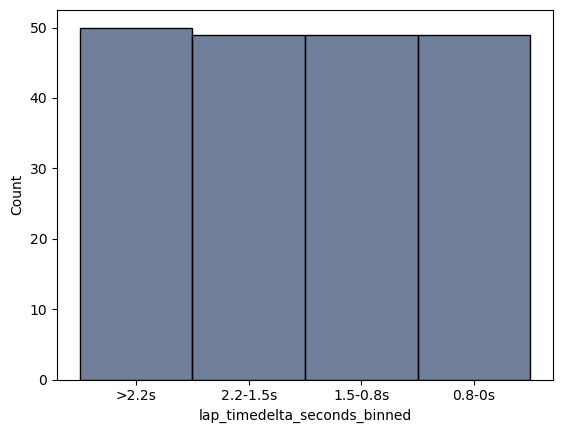

In [98]:
sns.histplot(data = qualifying_df ,x='lap_timedelta_seconds_binned',bins=20)

Here we demonstrate the 4 bins of Lap time delta are equal and now we have a classification problem for the model to predict whether are driver is:
- 0-0.8 seconds behind the fastest time
- 0.8 - 1.5 seconds
- 1.5 - 2.2 seconds
- or > 2.2 seconds.

## Evaluate Numerical Variables
<a id="num"></a>

We evaluate the distributions of the numerical variables to see how the feature aggregation performed in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb) did.

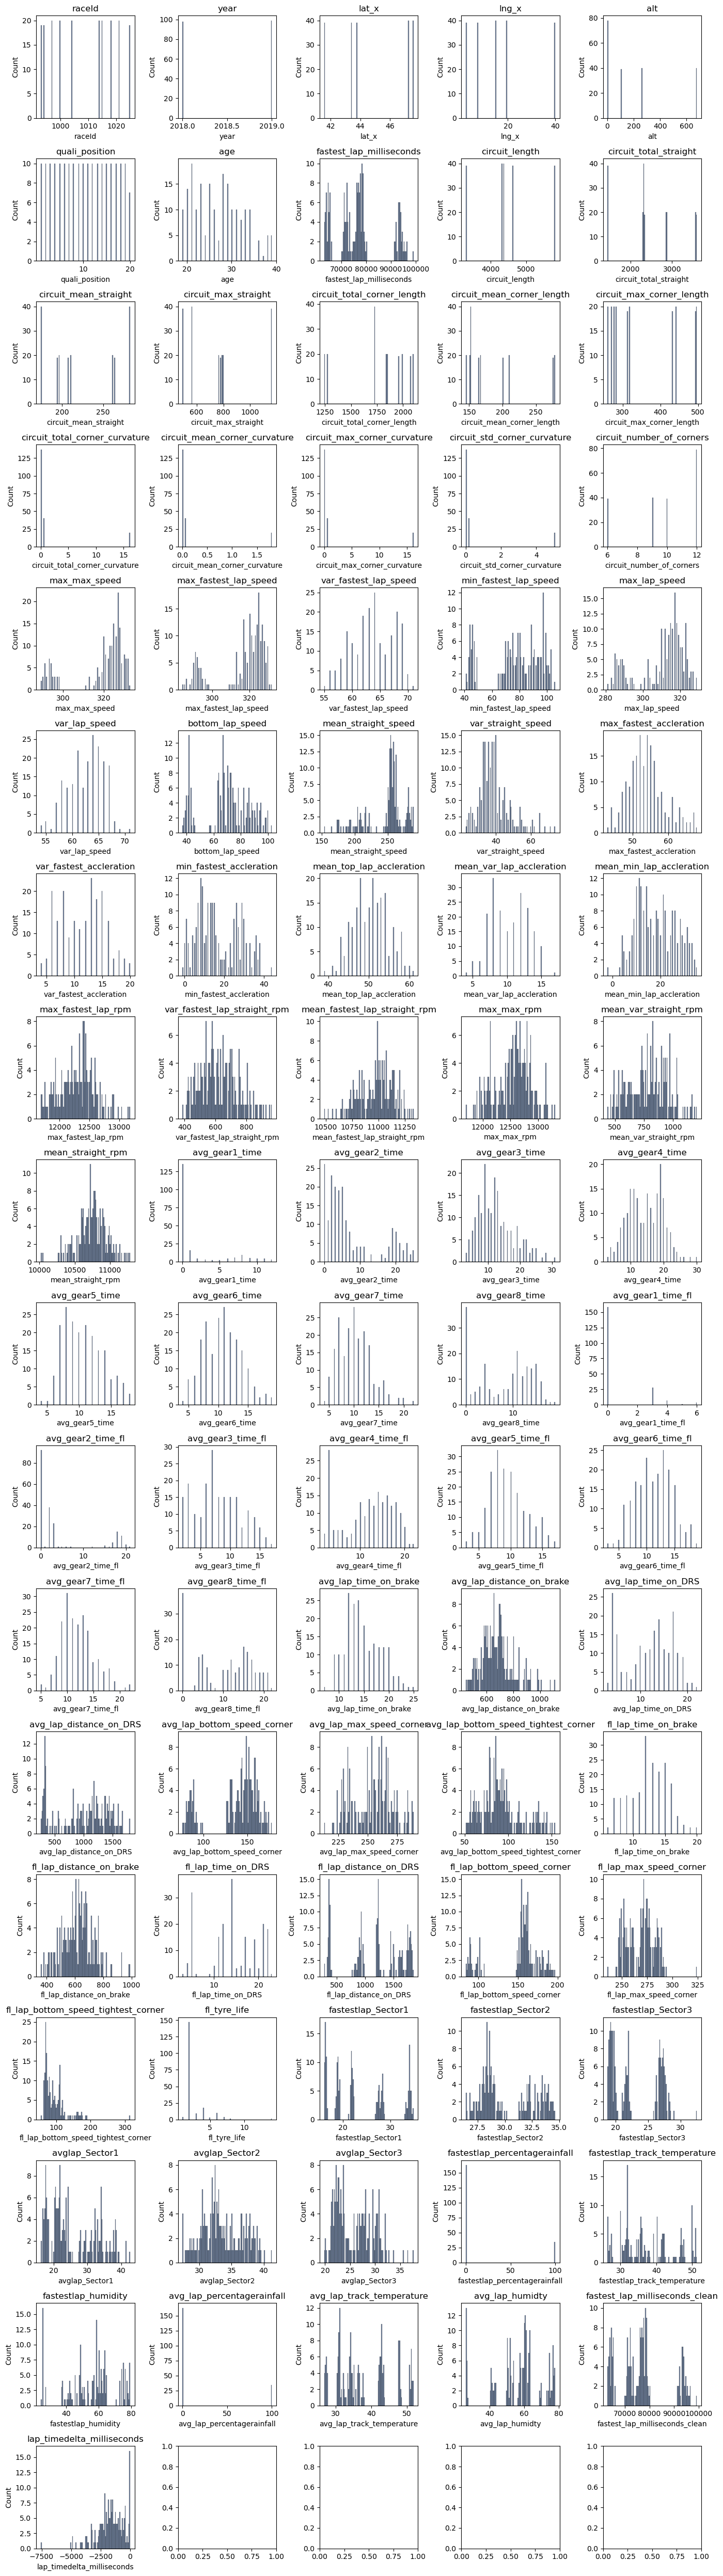

In [99]:
plot_numerical_variables_hist(qualifying_df)

From the distributions of the feature aggregations generated we can see 3 main types of distributions:
1. Normal distributions, variables such as :
    - Acceleration
    - Braking distance
    - RPM

Show normal distributions, these variables are more independent of circuit types and maybe respresent the differences in the drivers and cars


2. Clustered variables, variables which have cluster of data points:
    - Max fastest Speed
    - Bottom Speed Corner
    - Straight Speed

These variables have multiple normal distributions, most likely representation circuit variance. The distributions respond to different clusters of circuits.


3. Skewed distributions:
    - Circuit curviture
    - avg time in low gears
    - tyre life

These variables have a few outliers, for circuit curviture there is a few instances with much higher curvature values. This maybe true or generated from the feature aggregation algorithm and will have to be investigated further. The avg time in low gears is expected as most circuits will not need to go down to these gears whereas a few will. The occurences they do go into low gears will be short, unless the car has issues wich will be rare. Tyre life, drivers aim to set their fastest lap times when there tyres havent been used much to get the most out of fresh tyres for grip as they degrade over time. Therefore there is skewness of tyre life to low values.

## Evaluate Categorical Variables
<a id="cat"></a>

For the categorical variables we will plot the percentage occurence of the target variable by each type in the category, to see which category has a strong relationship with the target variable.

In [100]:
cat_list = list(qualifying_df.select_dtypes("object").columns)+list(qualifying_df.select_dtypes("category").columns)

In [101]:
def plot_categorical_cols_by_dim(df,dim,columns=5,**kwargs):
    figsize=(14,12)
    cat_list = list(df.select_dtypes("object").columns)+list(df.select_dtypes("category").columns)
    fig,axes=plt.subplots(math.ceil(len(df[cat_list].columns)/columns), columns, figsize=figsize)
    for col,axes in zip(df[cat_list].columns,axes.flatten()):
        total_count = df.groupby([col, dim])[col].count()
        pct_contact_type = total_count/df.groupby(col)[col].count()
        pct_contact_type = pct_contact_type.unstack()
        #print(pct_contact_type)
        #print(pct_contact_type.sort_values())    
        pct_contact_type.plot(kind="bar", stacked=True, ax=axes)
        sns.despine(left=True)
        axes.set_title(f"{col} group distribution", size=10)
    plt.tight_layout()
    plt.show()

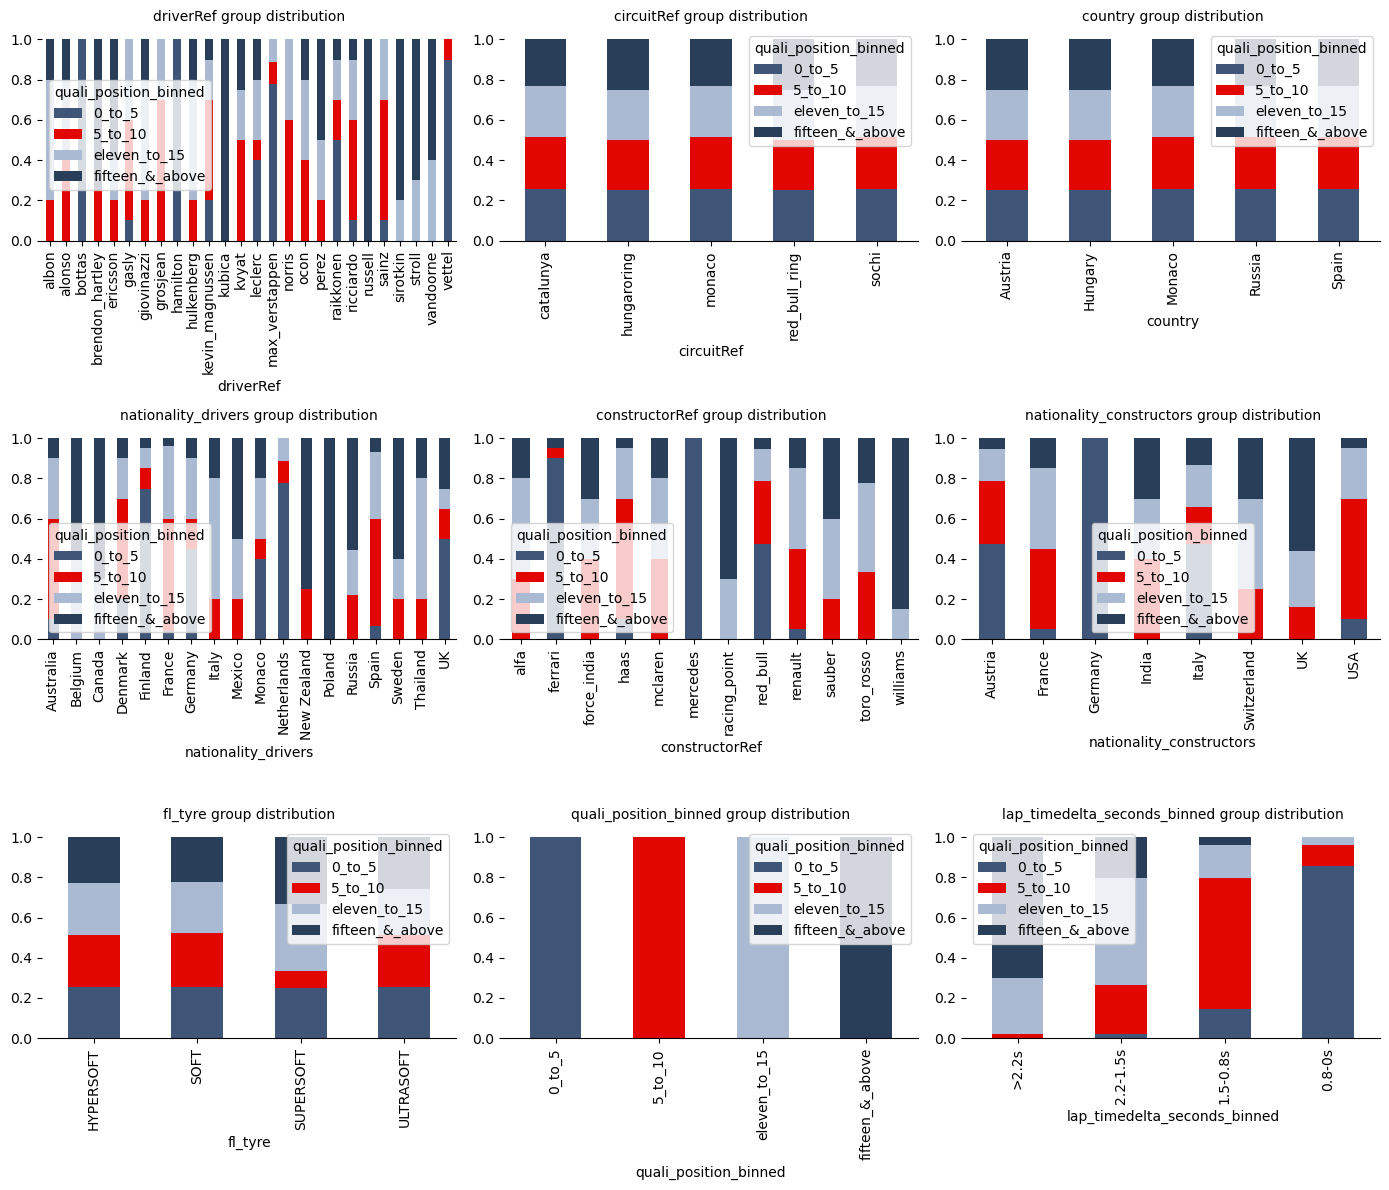

In [102]:
plot_categorical_cols_by_dim(qualifying_df,'quali_position_binned',columns=3)

We can see that driver name has a strong relationship with position, hamilton does not qualify outside the top 5 in 2018/19, whereas kuibca only qualifys in 15-20ths. Similarly the teams show a large variation with Merecedes performing the best and Williams the worst. The tyre life variable does not show much variation which was unexpected, this could be because the tyre choices are mandatated by the manufacturer before the race, and the teams all choose the softest one available out of the choice they are given. The other variables are either the target variables or related to nationality/ country of the circuit.

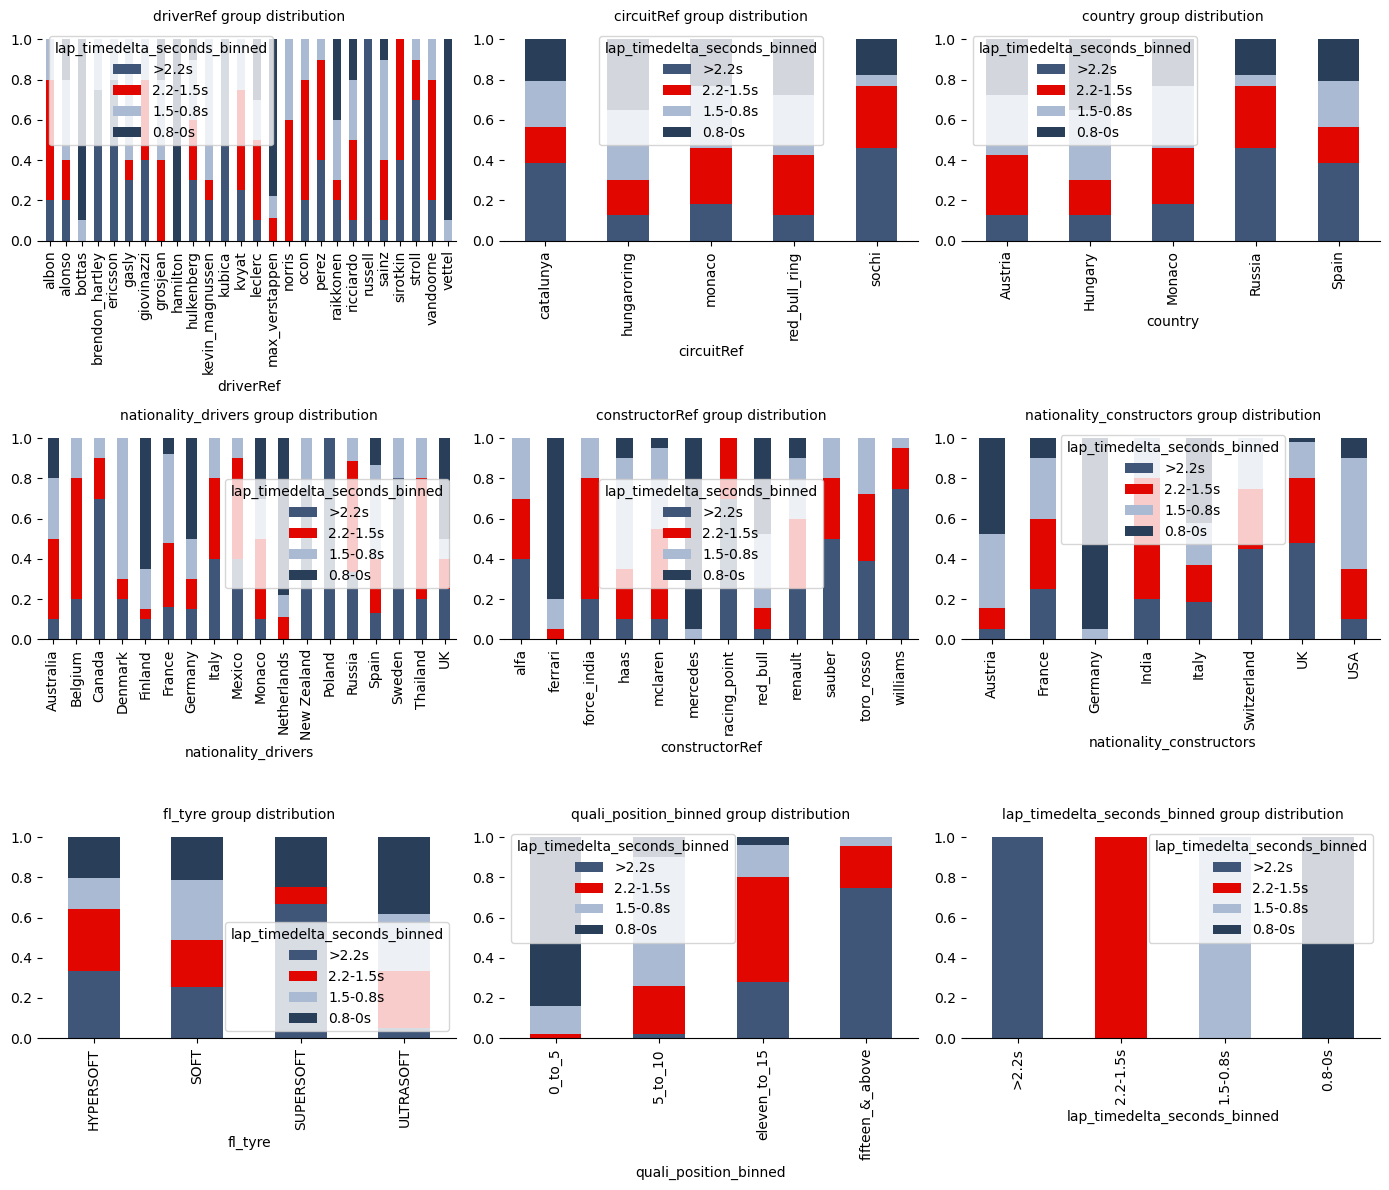

In [103]:
plot_categorical_cols_by_dim(qualifying_df,'lap_timedelta_seconds_binned',columns=3)

Similarly for Lap time delta, the drivers and teams show strong relationship with result. There is also a slight variability in the circuits, this is beacause possibily some ciruits are more challenging than others causing more spread in the drivers times than others. There is also a slighty variability on tyre types, this maybe due to lack of data from some tyres or that some tyres are more challenging that others causing bigger spread in results

The next to evaluate is the variability in the features that were created. We can run a correlation matrix and independence VIF test to see the results:

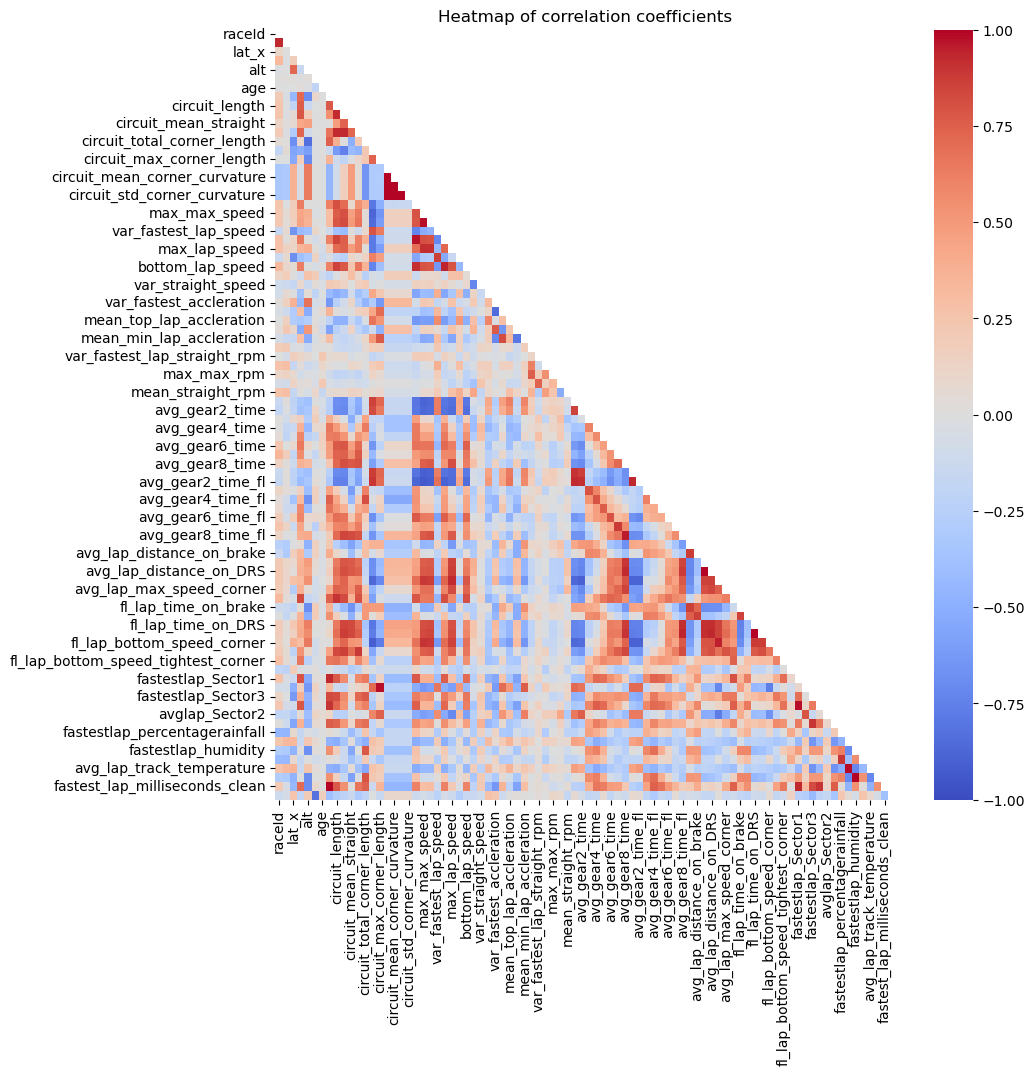

-------------------------------
VIF test results
Variation Inflation Factor : 
 raceId                                    inf
year                                      inf
lat_x                                     inf
lng_x                                     inf
alt                                       inf
                                     ...     
avg_lap_percentagerainfall           8.550628
avg_lap_track_temperature         1091.917154
avg_lap_humidty                    745.958006
fastest_lap_milliseconds_clean            inf
lap_timedelta_milliseconds         503.311420
Length: 86, dtype: float64
-----------------------------------


In [104]:
independence_test(qualifying_df,qualifying_df.select_dtypes("number").columns,annot=False)

What we can see is there is strong multicollinarity in many of the features created. This is because many of them are similar, for example the mean of all the laps , maximum of the laps the same variable but just averaged on the fastest lap, etc... Therefore leading to high multicollineraity. Going forward we will have to use techniques and regularisation that reducesthe impact of multicollinearity of the features.

### Linearity

The next step in the EDA for the new features process is to evaluate if any of the features created have a linear relationship with the target variable. For this we will evaluate the Pearson's R correlation coefficient with Qualifying Position and plot the correlaion (reg) plot between the variable and target.

Pearsonsr Statistical Correlation Test:
-----------------
raceId pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.009475774375959294, pvalue=0.8948613600493237)

year pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.008606279374697861, pvalue=0.9044606530793701)

lat_x pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.01993116766575037, pvalue=0.781016474717891)

lng_x pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.00036720819834713814, pvalue=0.995913880469354)

alt pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.017651434152185872, pvalue=0.8055334201434863)

quali_position pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=1.0, pvalue=0.0)

age pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=-0.19849463618642937, pvalue=0.005171492946783412)

fastest_lap_millisecond

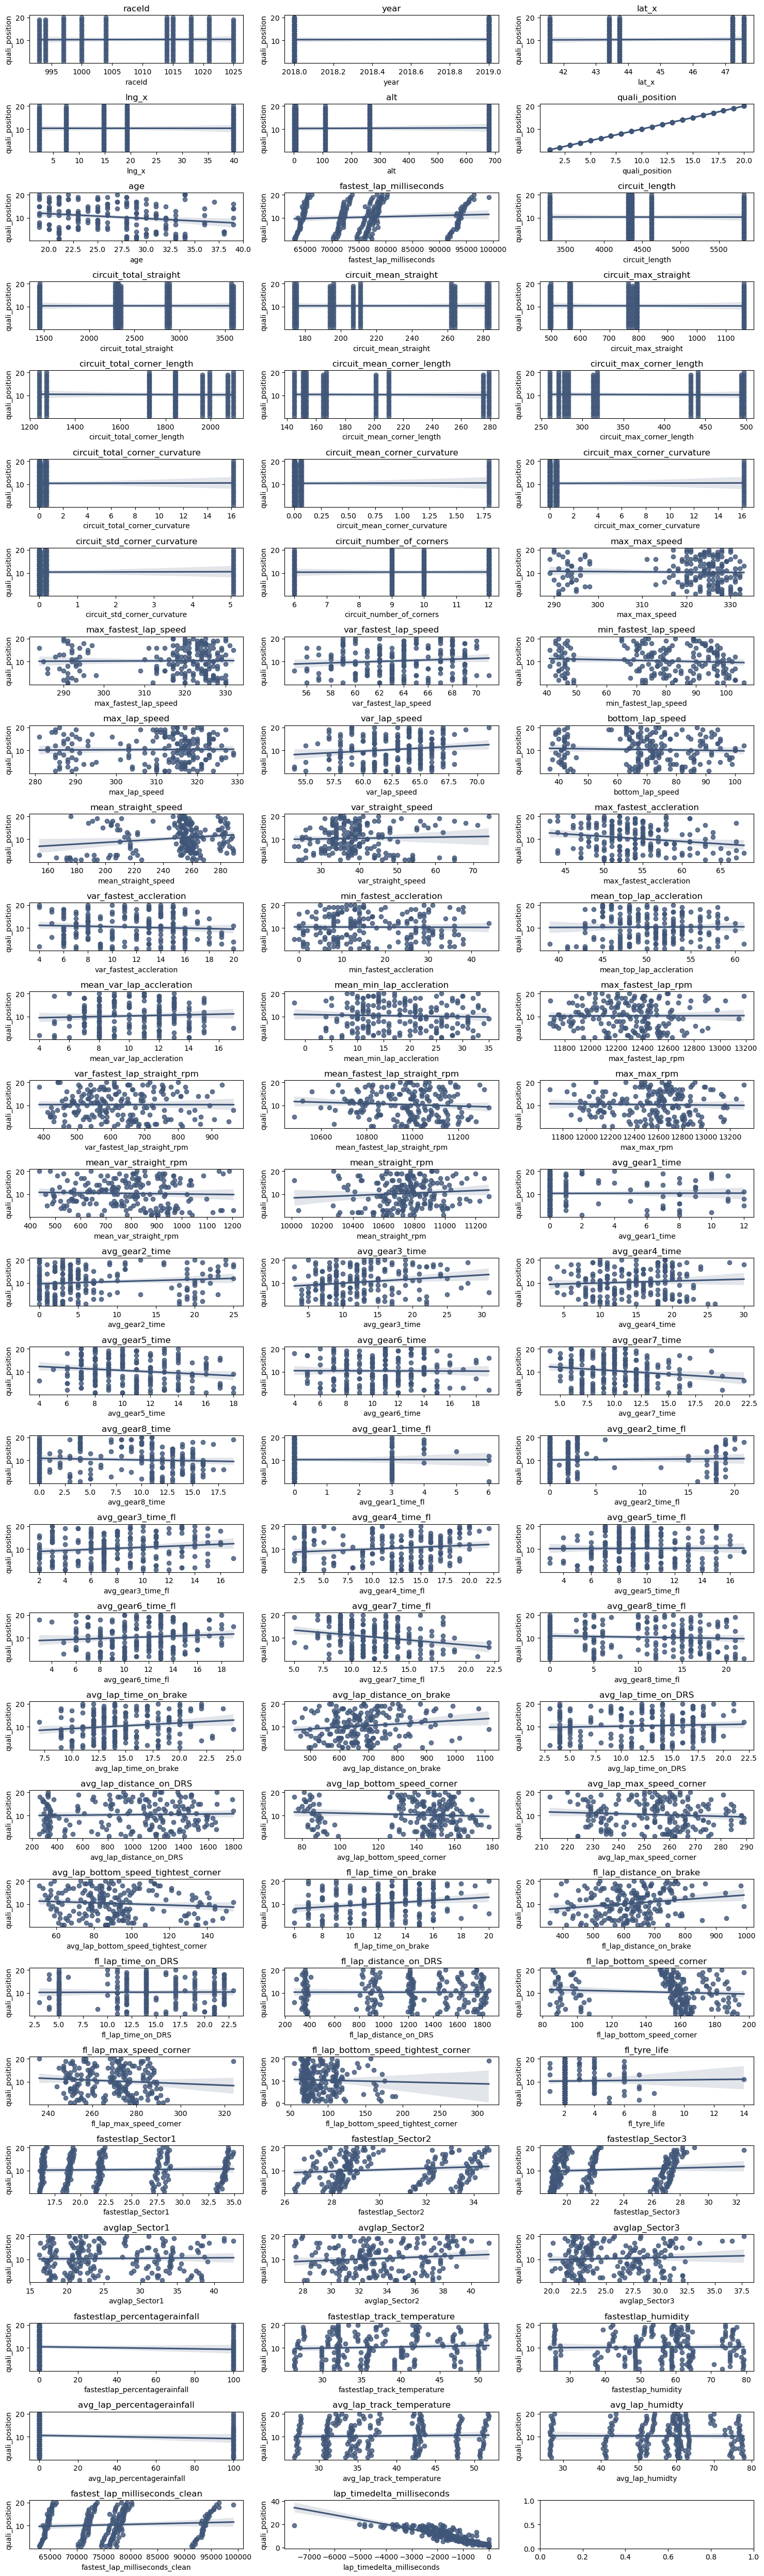

In [105]:
num_col=qualifying_df.select_dtypes("number").columns
correlation_test(qualifying_df,num_col,'quali_position',figsize=(15,50))

Ignoring the other target variable (`Lap time delta`) we can see there are variables with a linear relationship, including:
 - sector times
 - Time & Distance on Brake 
 - Time in gear 7 
 - RPM
 - Straight Variance & Speed
 - Accleration

It is expected that speed and accleration would have a linear relationship,a faster car is more likely to do better. However it was a surprise to see time in gear 7 having a linear relationship. Maybe this related to the performance of the engine, a car that acclerate fast through the gears and spend more time in gear 7 is likely to do better than one that doesn't.

Now we have explored the variables and see some the features created have a relationship we the target variable we can proceed to modelling.

# Prepare Data for Modelling
<a id="prep"></a>

Before modelling we need to split the data into features and target variables, split the data into test and train sets. Plus complete any final feature engineering.

## Feature Engineer Country Variables
<a id="country"></a>

In the plots above we saw the nationality and country variables were linked to the circuit and drivers respectively and therefore not very predictive on their own. However we can create a feature called home race, which is whether the race is in the home country of that driver or team.

In [106]:
qualifying_df['driver_home_race']=np.where(qualifying_df['country'] == qualifying_df['nationality_drivers'],1,0)

In [107]:
qualifying_df['constructor_home_race']= np.where(qualifying_df['country'] == qualifying_df['nationality_constructors'],1,0)

## Train Test split
<a id="testrain"></a>

We could just use Sklearn test train split and randomly split the dataset. However then we would be spliting drivers out from all the different races which is not represented of real life. Where the model will get data for all the drivers for one GrandPrix to predict. Hence we will instead take 2 GrandPrix's from 2019 as the test set and the rest of the data as the train set.

Plus split out the X and y features from the dataset 

In [108]:
query =(qualifying_df['circuitRef'].isin(['hungaroring','sochi'])) &(qualifying_df['year']==2019)
X_test = qualifying_df[query].drop(columns=['fastest_lap_milliseconds','fastest_lap_milliseconds_clean', 'lap_timedelta_milliseconds','quali_position','raceId']).copy()
X_train = qualifying_df[~query].drop(columns=['fastest_lap_milliseconds','fastest_lap_milliseconds_clean', 'lap_timedelta_milliseconds','quali_position','raceId']).copy()
y_test=qualifying_df.loc[query,['lap_timedelta_seconds_binned','quali_position_binned']]
y_train=qualifying_df.loc[~query,['lap_timedelta_seconds_binned','quali_position_binned']]

In [109]:
print(f'the number of data rows in the test set is {len(X_test)}')

the number of data rows in the test set is 39


In [110]:
print(f' the number of rows in the train data set is {len(X_train)}')

 the number of rows in the train data set is 158


The dataset is small so we have a small amount of data to train and test on. This is only the sample though and the aim is to just establish whether the feature aggregation gave features which were predictive.

In [111]:
X_train.head()

driverRef circuitRef country nationality_drivers constructorRef  \
0    alonso  catalunya   Spain               Spain        mclaren   
1    bottas  catalunya   Spain             Finland       mercedes   
2  ericsson  catalunya   Spain              Sweden         sauber   
3     gasly  catalunya   Spain              France     toro_rosso   
4  grosjean  catalunya   Spain              France           haas   

  nationality_constructors    year  lat_x    lng_x    alt  ...  \
0                       UK  2018.0  41.57  2.26111  109.0  ...   
1                  Germany  2018.0  41.57  2.26111  109.0  ...   
2              Switzerland  2018.0  41.57  2.26111  109.0  ...   
3                    Italy  2018.0  41.57  2.26111  109.0  ...   
4                      USA  2018.0  41.57  2.26111  109.0  ...   

   fastestlap_percentagerainfall  fastestlap_track_temperature  \
0                          100.0                          26.4   
1                          100.0                          26.4   
2                            0.0                          27.6   
3                          100.0                          26.8   
4                          100.0                          27.1   

   fastestlap_humidity  avg_lap_percentagerainfall  avg_lap_track_temperature  \
0                 79.2                       100.0                  27.255556   
1                 79.2                       100.0                  26.950000   
2                 76.1                         0.0                  27.620000   
3                 77.8                       100.0                  27.462500   
4                 77.1                       100.0                  27.135714   

   avg_lap_humidty  quali_position_binned  lap_timedelta_seconds_binned  \
0        77.311111                5_to_10                      1.5-0.8s   
1        77.883333                 0_to_5                        0.8-0s   
2        76.440000        fifteen_&_above                         >2.2s   
3        76.587500           eleven_to_15                         >2.2s   
4        77.350000                5_to_10                      1.5-0.8s   

   driver_home_race  constructor_home_race  
0                 1                      0  
1                 0                      0  
2                 0                      0  
3                 0                      0  
4                 0                      0  

[5 rows x 92 columns]

## Feature Enginer Categorical Variables
<a id="onehot"></a>

We still  have categorical variables in the X datasets, we need to one hot encode them into dummy variables for modelling. We can use Sklearn one hot encoder for this

In [112]:
encoder=OneHotEncoder()
encoder.fit(X_train['driverRef'].values.reshape(-1,1))
X_train_drivers_x= encoder.transform(X_train['driverRef'].values.reshape(-1,1))
X_test_drivers_x=encoder.transform(X_test['driverRef'].values.reshape(-1,1))
X_train_drivers_df =pd.DataFrame(data=X_train_drivers_x.toarray(),columns=encoder.get_feature_names_out())
X_test_drivers_df =pd.DataFrame(data=X_test_drivers_x.toarray(),columns=encoder.get_feature_names_out())

In [113]:
encoder=OneHotEncoder()
encoder.fit(X_train['circuitRef'].values.reshape(-1,1))
X_train_circuit_x= encoder.transform(X_train['circuitRef'].values.reshape(-1,1))
X_train_circuit_df =pd.DataFrame(data=X_train_circuit_x.toarray(),columns=encoder.get_feature_names_out())
X_test_circuit_x= encoder.transform(X_test['circuitRef'].values.reshape(-1,1))
X_test_circuit_df =pd.DataFrame(data=X_test_circuit_x.toarray(),columns=encoder.get_feature_names_out())



In [114]:
encoder=OneHotEncoder()
encoder.fit(X_train['constructorRef'].values.reshape(-1,1))
cons_x= encoder.transform(X_train['constructorRef'].values.reshape(-1,1))
X_train_cons_df =pd.DataFrame(data=cons_x.toarray(),columns=encoder.get_feature_names_out())
X_test_cons_x= encoder.transform(X_test['constructorRef'].values.reshape(-1,1))
X_test_cons_df =pd.DataFrame(data=X_test_cons_x.toarray(),columns=encoder.get_feature_names_out())

In [115]:
encoder=OneHotEncoder()
encoder.fit(X_train['constructorRef'].values.reshape(-1,1))
cons_x= encoder.transform(X_train['constructorRef'].values.reshape(-1,1))
X_train_cons_df =pd.DataFrame(data=cons_x.toarray(),columns=encoder.get_feature_names_out())
X_test_cons_x= encoder.transform(X_test['constructorRef'].values.reshape(-1,1))
X_test_cons_df =pd.DataFrame(data=X_test_cons_x.toarray(),columns=encoder.get_feature_names_out())

Merge the dummy variable dataframes back together into one train and test set.

In [116]:
X_train= pd.concat([X_train.select_dtypes("number"),X_train_cons_df,X_train_circuit_df,X_train_drivers_df],axis=1)
X_test= pd.concat([X_test.select_dtypes("number").reset_index(drop=True),X_test_cons_df,X_test_circuit_df,X_test_drivers_df],axis=1)

## Label Target Variables
<a id="label"></a>

In addittion the target varibles are class labels for the bin, these need to be converted to numerical codes for modelling, therefore convert the class labels into a number.

In [117]:
y_train

lap_timedelta_seconds_binned quali_position_binned
0                       1.5-0.8s               5_to_10
1                         0.8-0s                0_to_5
2                          >2.2s       fifteen_&_above
3                          >2.2s          eleven_to_15
4                       1.5-0.8s               5_to_10
..                           ...                   ...
153                     2.2-1.5s          eleven_to_15
154                        >2.2s       fifteen_&_above
155                     1.5-0.8s          eleven_to_15
156                     2.2-1.5s       fifteen_&_above
157                       0.8-0s               5_to_10

[158 rows x 2 columns]

We can use Sklearn's Label encoder for this:

In [118]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
y1_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
y1_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])

In [119]:
labelencoder.classes_

array(['0.8-0s', '1.5-0.8s', '2.2-1.5s', '>2.2s'], dtype=object)

In [120]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
y2_train= labelencoder.transform(y_train['quali_position_binned'])
y2_test= labelencoder.transform(y_test['quali_position_binned'])
labelencoder.classes_

array(['0_to_5', '5_to_10', 'eleven_to_15', 'fifteen_&_above'],
      dtype=object)

### Scale the data

We saw from the distributions the variables have a wide range of magnitudes. To reduce the model becoming baises to the variables with large magnitudes we will scale all the variables to the same magnitude. In addition some the variables are skewed, therefore we do not want to use a min max scaler as the outliers will affect the data. We will use a standard scaler which is less affected by outliers.

In [121]:
# scale data

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Feature Importance
<a id="feature"></a>

Now the data is prepared for modelling, we run 3 different techniques to find out feature importance. THese are:
1. Random Forest: Random Forest uses an ensemble of decision tress, in the process it learns through information gain which are the important features that help the model polarise and classify the data. We will run a basic random forest model and see which features it selected. 

2. Select K Best: Select K best calculates the ANOVA statistical test between the target variable each feature in the dataset. We can use this to plot the scores for each variable.

3. Principal Component analysis: PCA reduces the dimensionality of the data by converting the features into features which best represent the variance in the data. I.e. rotating the data along the axis of maximum variance in the data. Can PCA help reduce the data into a low dimensionality?

For this analysis we will focus on the target variable of Qualifying Position

## Random Forest Feature Importance
<a id="rf"></a>

First for Random Forest we will fit a simple Random Forest model to the data. 

In [122]:
rf=RandomForestClassifier()
rf_model = rf.fit(X_train_scaled,y1_train)

In [123]:
rf_model.feature_importances_

array([0.00138914, 0.00401042, 0.00229193, 0.00237354, 0.01980239,
       0.00378234, 0.0021166 , 0.00339091, 0.00157786, 0.00332272,
       0.00308823, 0.0029593 , 0.00718551, 0.00318158, 0.0039381 ,
       0.00182115, 0.00070736, 0.01240127, 0.01484542, 0.00706572,
       0.0127048 , 0.00817751, 0.00779186, 0.01052134, 0.01616403,
       0.02626998, 0.00631383, 0.00766286, 0.00726236, 0.01163888,
       0.00505244, 0.00807552, 0.01697986, 0.01577379, 0.01760544,
       0.01182647, 0.02268184, 0.0117677 , 0.00498092, 0.01417189,
       0.01032301, 0.00984256, 0.01034264, 0.01036682, 0.00900906,
       0.00823991, 0.00086046, 0.00474472, 0.01111914, 0.01295451,
       0.00715829, 0.00714508, 0.00971724, 0.01346442, 0.00741036,
       0.00988665, 0.00481737, 0.00900231, 0.01445016, 0.01006459,
       0.013093  , 0.00615167, 0.00761178, 0.00359015, 0.01094932,
       0.02030564, 0.01015213, 0.01073153, 0.00477849, 0.02438347,
       0.0806339 , 0.05585168, 0.01531447, 0.01852359, 0.02395

Out of Random Forest we can get an array of feature importance for each feature, a high number means that variable is more important to help the model predict the target. We can summarise this in a dataframe.

In [124]:
RF_results = pd.DataFrame(data=rf_model.feature_importances_ ,index=X_train.columns)

In [125]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [126]:
RF_results.sort_values(by='Random_forest_result',ascending=False).head(30)

Random_forest_result
fastestlap_Sector2                                0.080634
fastestlap_Sector3                                0.055852
x0_mercedes                                       0.032990
var_straight_speed                                0.026270
fastestlap_Sector1                                0.024383
avglap_Sector3                                    0.023957
mean_var_straight_rpm                             0.022682
fl_lap_bottom_speed_corner                        0.020306
age                                               0.019802
avglap_Sector2                                    0.018524
mean_fastest_lap_straight_rpm                     0.017605
max_fastest_lap_rpm                               0.016980
avg_lap_track_temperature                         0.016597
avg_lap_humidty                                   0.016247
mean_straight_speed                               0.016164
var_fastest_lap_straight_rpm                      0.015774
avglap_Sector1                                    0.015314
max_fastest_lap_speed                             0.014845
avg_lap_bottom_speed_corner                       0.014450
avg_gear2_time                                    0.014172
x0_ferrari                                        0.013756
avg_gear8_time_fl                                 0.013464
avg_lap_bottom_speed_tightest_corner              0.013093
avg_gear4_time_fl                                 0.012955
min_fastest_lap_speed                             0.012705
max_max_speed                                     0.012401
max_max_rpm                                       0.011826
mean_straight_rpm                                 0.011768
mean_top_lap_accleration                          0.011639
fastestlap_track_temperature                      0.011427

We can see that the sector times are the best predictors of the Qualifying position which makes sense as they are the sector times for the fastest lap. Then interstingly the variance in straight line speed is good predictor, this maybe due to cars which perform better are more consistently fast over the whole lap whereas ones that don't show more variance.

Then as expected the mercedes dummy variable does well as mercedes have dominated in the two years of 2018 and 2019.

Humidity and track temperature were unexpected variables to be good predictors, maybe cars who get laps out when the track is warmer do better. Worth investigating

## Select K Best
<a id="kbest"></a>

What about statistical significance? Which ones are more statistically significant? We can use SKlearn SelectKbeast function to find the scores for each variable and save it to a dataframe.

In [127]:
select=SelectKBest()
sel_model=select.fit(X_train_scaled,y1_train)

In [128]:
X_train.columns[sel_model.get_support()]

Index(['age', 'mean_straight_speed', 'fastestlap_Sector3', 'avglap_Sector3',
       'x0_ferrari', 'x0_mercedes', 'x0_williams', 'x0_bottas', 'x0_hamilton',
       'x0_vettel'],
      dtype='object')

In [129]:
select_results = pd.DataFrame(data=sel_model.scores_ ,index=X_train.columns)

In [130]:
select_results.rename(columns={0:'SelectKbest_result'},inplace=True)

In [131]:
select_results.sort_values(by='SelectKbest_result',ascending=False).head(30)

SelectKbest_result
x0_mercedes                             25.558368
x0_hamilton                              9.584388
x0_bottas                                9.584388
x0_ferrari                               9.367076
x0_williams                              9.096920
fastestlap_Sector3                       8.343445
avglap_Sector3                           8.081545
mean_straight_speed                      6.565837
x0_vettel                                6.415507
age                                      6.310242
var_straight_speed                       5.813820
lat_x                                    5.418410
var_lap_speed                            5.212519
avg_gear4_time_fl                        5.169499
fastestlap_percentagerainfall            4.304695
avg_lap_percentagerainfall               4.304695
circuit_max_straight                     4.210630
fastestlap_Sector2                       4.156517
mean_var_straight_rpm                    3.952408
x0_hungaroring                           3.929722
x0_sochi                                 3.759955
x0_kevin_magnussen                       3.655250
x0_russell                               3.603376
x0_kubica                                3.603376
x0_ericsson                              3.511820
max_fastest_accleration                  3.373363
x0_haas                                  3.168983
x0_red_bull                              3.036030
avg_gear4_time                           3.012818
x0_stroll                                2.953384

Here we can see that Select K best found more of the dummy variables have a strong statistical significance with qualifying position. Especially Mercedes. We saw that in the EDA that mercedes didn't qualify outside the top5 in our sample.

Howeer other interesting variables such as straight line speed was statistically significant and the average time in gear 4 interestingly. Maybe drivers who quickly pass through gear 4 into higher gears are acclerating faster and do better?

## Principal Component Analysis
<a id="pca"></a>

The third technique is PCA. As mentioned this aims to reduce dimensionality by translating the data into the components of maximum variance.

We can find the components that explain 90% of the data:

In [132]:
#only take the components that explain 90% of the data:

my_pca=PCA(n_components=0.9)
my_pca.fit(X_train_scaled)

PCA(n_components=0.9)

How does this plot which components explain the most variance?

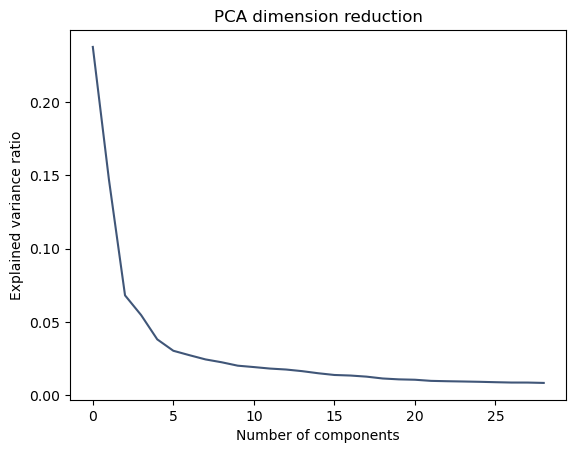

In [133]:
plt.figure()
plt.plot(np.arange(0,my_pca.n_components_,1),my_pca.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.title('PCA dimension reduction')
plt.show()

From this plot we can see that PCA 1 and 2 explain together over 30% of the variance, after that the result explain much smaller amounts of the variance in the data.

How many components explain 90% of the data variance?

In [134]:
print(f' {my_pca.n_components_} components explain 90% of the variance')

 29 components explain 90% of the variance


Can we see what features PCA 1 and 2 are made up of? We can look at the variance components for these using the method (.components_) and just take the results for PCA 1 and 2. 

A high positive or negative number means that feature contributed to that component. A value close to 0 means no contribution.

In [135]:
pca_results = pd.DataFrame(data=my_pca.components_[0:2],columns=X_train.columns,index=['PCA1','PCA2'])

In [136]:
pca_results.T.abs().sort_values(by='PCA1',ascending=False)

PCA1      PCA2
avg_lap_bottom_speed_corner  0.176193  0.038245
x0_monaco                    0.175086  0.032307
fl_lap_bottom_speed_corner   0.173170  0.035992
avg_gear2_time_fl            0.172694  0.048207
max_max_speed                0.171795  0.015648
...                               ...       ...
x0_leclerc                   0.000707  0.001247
x0_mclaren                   0.000665  0.007084
x0_sainz                     0.000260  0.001035
x0_kevin_magnussen           0.000218  0.000796
x0_sirotkin                  0.000043  0.016348

[126 rows x 2 columns]

We can plot the results for PCA and take the absolute so features close to 0 are low contribution and high values are high contribution

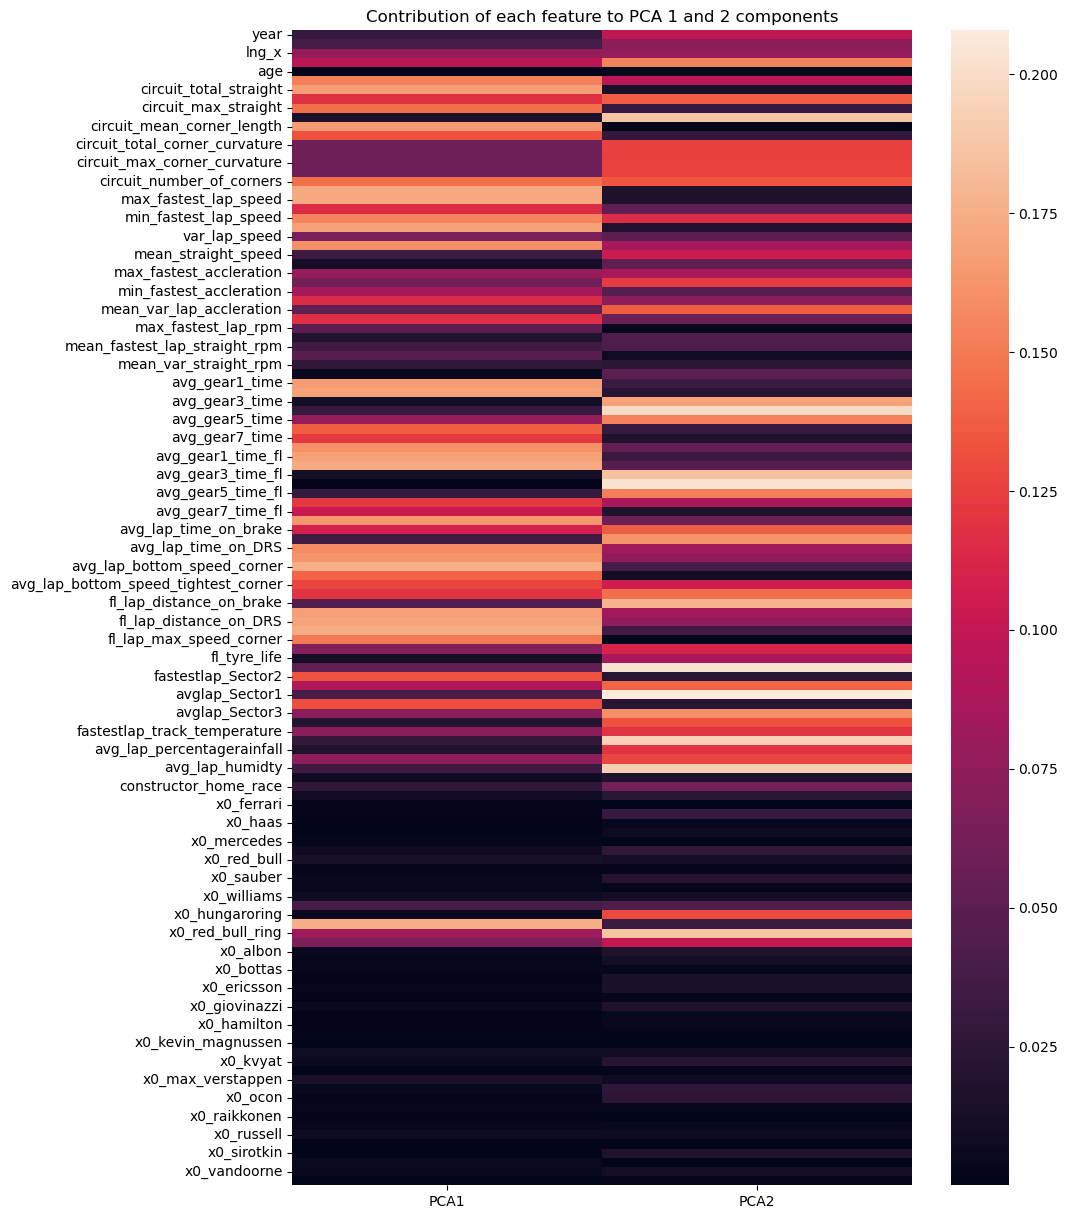

In [137]:

plt.figure(figsize=(10,15))
plt.title('Contribution of each feature to PCA 1 and 2 components')
sns.heatmap(pca_results.T.abs())
plt.show()

Here we can see that PCA 1 is mostly made up of variables we saw had a relationship in our EDA. This is distance on DRS, time in gears, Speed on straights and some circuit features. PCA2 took the opposite features, including Sector times other gear times and some circuit features.

Both PCA 1 and 2 had little contribution from Driver and Team dummy variables. This is different to Random Forest and Select K Best.

## Summary of Feature Importance
<a id="sumfeature"></a>

We can combine and scale the results of these methods to compare the results.

In [138]:
all_results = pd.concat([RF_results,select_results,pca_results.T.abs()],axis=1)

In [139]:
#We need to scale the results as they all have different metrics so to compare we need to scale the values

scaler=StandardScaler()
all_results_scaled = scaler.fit_transform(all_results)

In [140]:
all_results_2 = pd.DataFrame(data=all_results_scaled,index=all_results.index,columns=all_results.columns)

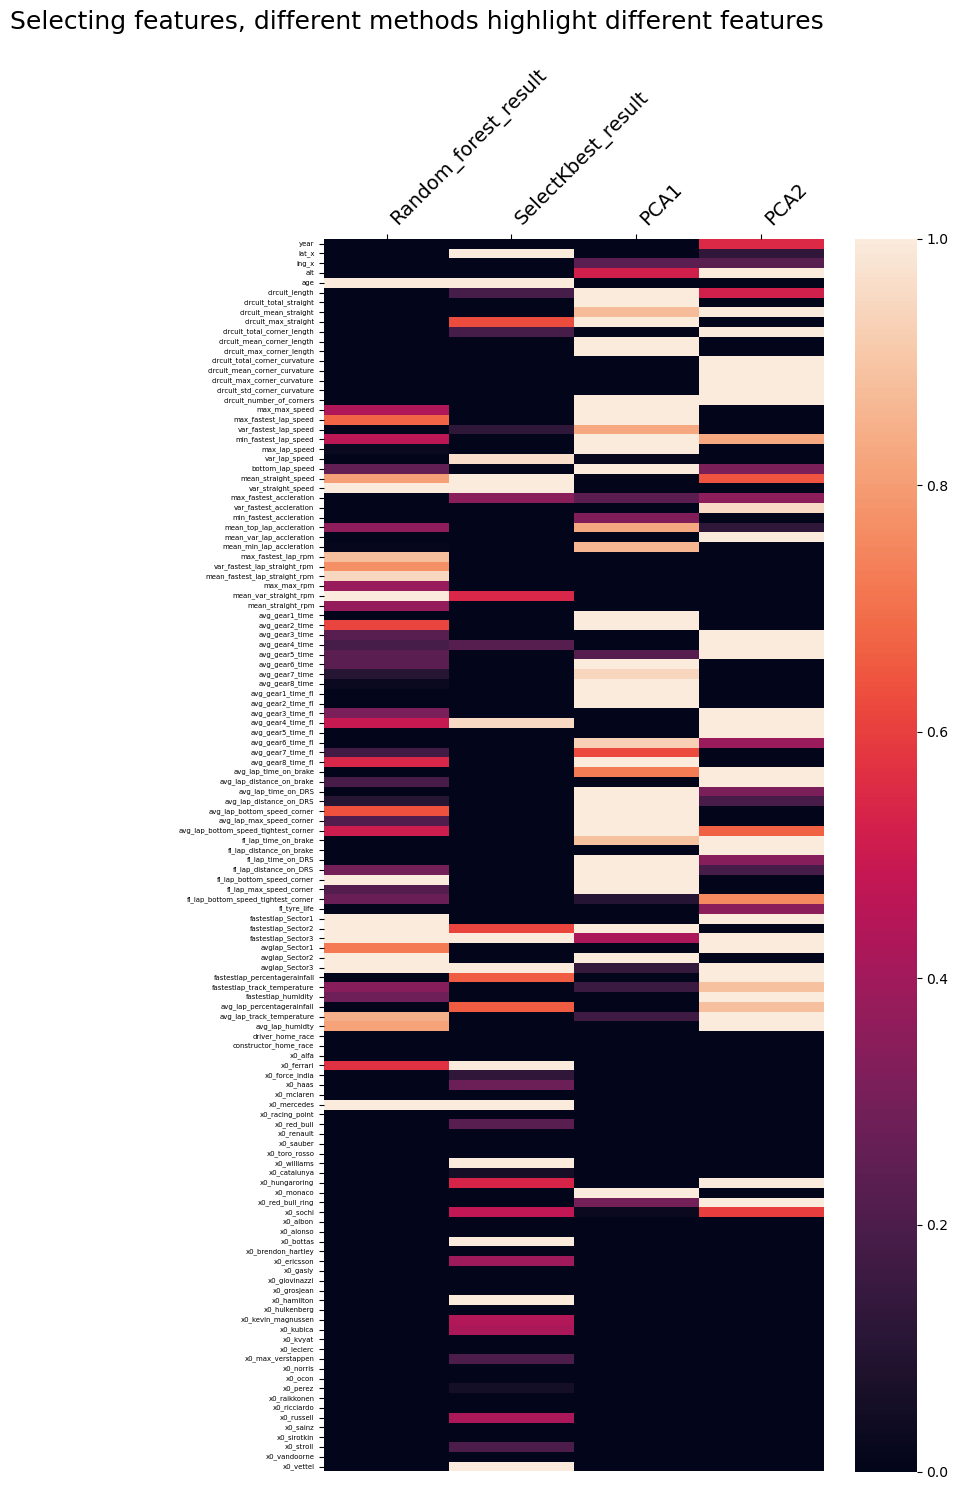

In [141]:
plt.figure(figsize=(8,15))
sns.heatmap(all_results_2, vmax=1, vmin=0)

plt.gca().xaxis.tick_top()
plt.title('Selecting features, different methods highlight different features\n',loc='right',fontsize=18)
plt.xticks(rotation = 45,ha='left',fontsize=14)
plt.yticks(np.arange(0.5,(len(all_results_2.index)+0.5)),labels=all_results_2.index,va="center",fontsize=5)
#plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('./images/feature_selection_full.jpg',dpi=300,bbox_inches='tight')
plt.show()


We can see that the methods picked out some similar and different feature that are important to predict Qualifying Position.

Random forest was more impacted by:
- Sector Times
- Mercedes as thetop team
- Speed on the straight
- Gear 4 time 
- Weather

Wheras Select K Best had some similar features by was more showing the dummy variables of Teams and Drivers as more statistical significant.

PCA focus on the feature aggreagation, particularly focusing on:
- DRS variables
- Braking variables
- Time in gears
- Sector times
- and circuit variables



# Summary:
<a id="sum"></a>

In summary we have shown that the features we created by aggregating the telemetry data from the individual laps has predictive power in Qualifying Position and Lap Time delta.

- Some of the variables have some linearity with the target variable
- 3 Different feature importance techniques picked out different variables of interest. However they all agreed that some of the features generated from the telemetry data were useful in predicting the Target Variable

The result of this investigation is we can confirm that the features generated are useful and that we can proceed to download the data for the rest of the GrandPrix's between 2018 to 2022 and generate the same features that were generated on the sample dataset.

# Next Steps:
<a id="nextsteps"></a>
The next steps is to repeat the feature aggregation for the whole dataset. However compared to the sample downloading all the lap data first and then aggregating will max out the RAM of the laptop, so we will turn the feature aggregations into function to run the aggregations for each driver and grandprix in sequence.

Once we proceed to modelling we will test two approaches to dimension reduction. 
1. Using the highest scoring features from Random Forest and Select K best
2. Using the top PCA components generated on the whole dataset

We will then investigate which is best in predicting the target variables.


# Appendix:
<a id="appendix"></a>

A simple logistic regression model was built and tested on the sample dataset below:

## Logisitic Regression Simple Model

In [142]:

model = LogisticRegression(max_iter=100000)
model.fit(X_train_scaled,y1_train)
print(f'Train Accuracy: {model.score(X_train_scaled, y1_train)}')
#4. Score on testing data
print(f'Test Accuracy: {model.score(X_test_scaled, y1_test)}')

Train Accuracy: 1.0
Test Accuracy: 0.48717948717948717


In [143]:
results = pd.DataFrame(model.coef_,columns=X_train.columns).T
print(results.head(93))

                        0         1         2         3
year            -0.426935  0.436709  0.001756 -0.011530
lat_x            0.137495  0.112581 -0.046936 -0.203140
lng_x            0.078035 -0.036060  0.070898 -0.112874
alt              0.016228 -0.050015  0.015730  0.018057
age              0.415453 -0.034231 -0.160201 -0.221021
...                   ...       ...       ...       ...
x0_mercedes      0.982933 -0.456954 -0.226146 -0.299833
x0_racing_point -0.149316 -0.435752  0.222940  0.362129
x0_red_bull      0.420358  0.130104 -0.258236 -0.292226
x0_renault       0.107282  0.048458  0.038634 -0.194374
x0_sauber       -0.421065 -0.004877  0.117346  0.308597

[93 rows x 4 columns]


In [144]:
print(results[results.all(1)!=0.0].index)

Index(['year', 'lat_x', 'lng_x', 'alt', 'age', 'circuit_length',
       'circuit_total_straight', 'circuit_mean_straight',
       'circuit_max_straight', 'circuit_total_corner_length',
       ...
       'x0_ocon', 'x0_perez', 'x0_raikkonen', 'x0_ricciardo', 'x0_russell',
       'x0_sainz', 'x0_sirotkin', 'x0_stroll', 'x0_vandoorne', 'x0_vettel'],
      dtype='object', length=126)


In [145]:
cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
results_dict={}
train_acc=[]
test_acc=[]
for c in cs:
    print(c)
    model = LogisticRegression(solver='liblinear',penalty='l1',C=c,max_iter=10000)
    model.fit(X_train_scaled,y1_train)
    print(f'Train Accuracy: {model.score(X_train_scaled, y1_train)}')
    train_acc.append(model.score(X_train_scaled, y1_train))    
    print(f'Test Accuracy: {model.score(X_test_scaled, y1_test)}')
    test_acc.append(model.score(X_test_scaled, y1_test))
    results_dict[c]= pd.DataFrame(model.coef_,columns=X_train.columns).T

0.001
Train Accuracy: 0.25316455696202533
Test Accuracy: 0.23076923076923078
0.01
Train Accuracy: 0.25316455696202533
Test Accuracy: 0.23076923076923078
0.1
Train Accuracy: 0.6772151898734177
Test Accuracy: 0.6410256410256411
1
Train Accuracy: 0.9620253164556962
Test Accuracy: 0.48717948717948717
10
Train Accuracy: 1.0
Test Accuracy: 0.41025641025641024
100
Train Accuracy: 1.0
Test Accuracy: 0.4358974358974359
1000
Train Accuracy: 1.0
Test Accuracy: 0.46153846153846156
10000
Train Accuracy: 1.0
Test Accuracy: 0.46153846153846156


In [146]:
for key in results_dict:
    print(key)
    df=results_dict[key].copy()
    print(df[df.all(1)!=0.0].index)

0.001
Index([], dtype='object')
0.01
Index([], dtype='object')
0.1
Index([], dtype='object')
1
Index(['var_straight_speed', 'max_max_rpm', 'driver_home_race', 'x0_mercedes',
       'x0_kevin_magnussen'],
      dtype='object')
10
Index(['var_straight_speed', 'mean_top_lap_accleration', 'max_max_rpm',
       'fl_tyre_life', 'fastestlap_percentagerainfall', 'driver_home_race',
       'x0_red_bull', 'x0_gasly', 'x0_hamilton', 'x0_hulkenberg',
       'x0_kevin_magnussen', 'x0_sainz'],
      dtype='object')
100
Index(['var_lap_speed', 'var_straight_speed', 'mean_top_lap_accleration',
       'mean_var_lap_accleration', 'max_max_rpm', 'avg_gear4_time',
       'fl_tyre_life', 'avg_lap_percentagerainfall', 'driver_home_race',
       'x0_red_bull', 'x0_gasly', 'x0_hamilton', 'x0_hulkenberg',
       'x0_kevin_magnussen', 'x0_ricciardo', 'x0_sainz'],
      dtype='object')
1000
Index(['var_lap_speed', 'var_straight_speed', 'max_fastest_accleration',
       'min_fastest_accleration', 'mean_top_lap_ac